In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import scipy.stats as stat
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
import pickle
from sklearn.metrics import *
import pandas as pd
import seaborn as sns
import statsmodels
from itertools import cycle

In [2]:
from all_models import *

In [6]:
# read fit values
fits_single = pickle.load(open('fit_single_CV_640_bestfit_starting_point.pickle', 'rb'))
fits_dual = pickle.load(open('fit_dual_CV_640_bestfit_starting_point.pickle', 'rb'))
fits_hybrid = pickle.load(open('fit_hybrid_CV_704.pickle', 'rb'))
#fits_eight = pickle.load(open('fit_dual_eight_CV_704.pickle', 'rb'))
#fits_six = pickle.load(open('fit_six_CV_704.pickle', 'rb'))
#fits_mixed = pickle.load(open('fit_mixed_CV_704.pickle', 'rb'))
#fits_single_transfer = pickle.load(open('fit_single_CV_transfer.pickle', 'rb'))
#fits_dual_transfer = pickle.load(open('fit_dual_CV_transfer.pickle', 'rb'))
fits_dual_meaned = pickle.load(open('fit_dual_meaned_CV_704.pickle', 'rb'))
fits_single_meaned = pickle.load(open('fit_single_meaned_CV_704.pickle', 'rb'))

fits_alpha = pickle.load(open('fit_dual_2alpha_CV_704.pickle', 'rb'))

curvatures_smooth = pickle.load(open('curvatures_smooth.pickle', 'rb'))

curvatures_smooth = curvatures_smooth/90.0
curvatures = pickle.load(open('curvatures.pickle', 'rb'))

In [3]:
fits = pickle.load(open('fit_nocv_640.pickle', 'rb'))

In [4]:
fits_single_nocv = np.vstack(fits[:, 0])
fits_dual_nocv = np.vstack(fits[:, 1])

In [5]:
A = fits_single_nocv[:, 0]
B = fits_single_nocv[:, 1]
Af = fits_dual_nocv[:, 0]
Bf = fits_dual_nocv[:, 1]
As = fits_dual_nocv[:, 2]
Bs = fits_dual_nocv[:, 3]


In [10]:
params_df = pd.DataFrame({'participant_id': np.repeat(np.arange(64), 6), 
                          'rotation': np.tile(np.repeat(np.repeat(['Sudden', 'Gradual'], 2), 6), 16),
                          'emphasis': np.repeat(['Accuracy', 'Speed'], 6*32),
                          'parameter': np.tile(['A', 'B', 'Af', 'Bf', 'As', 'Bs'], 64),
                          'parameter_values': np.ravel([A, B, Af, Bf, As, Bs], order='F'),
                          'model': np.tile(['single_state', 'single_state', 'dual_state', 'dual_state', 'dual_state', 'dual_state'], 64)
                         })

In [11]:
params = params_df.drop(columns='model', axis = 0).pivot(index=['participant_id', 'rotation', 'emphasis'], columns=['parameter']).reset_index()

In [12]:
params.columns = np.concatenate([params.columns.get_level_values(0)[:3], params.columns.get_level_values(1)[3:]])


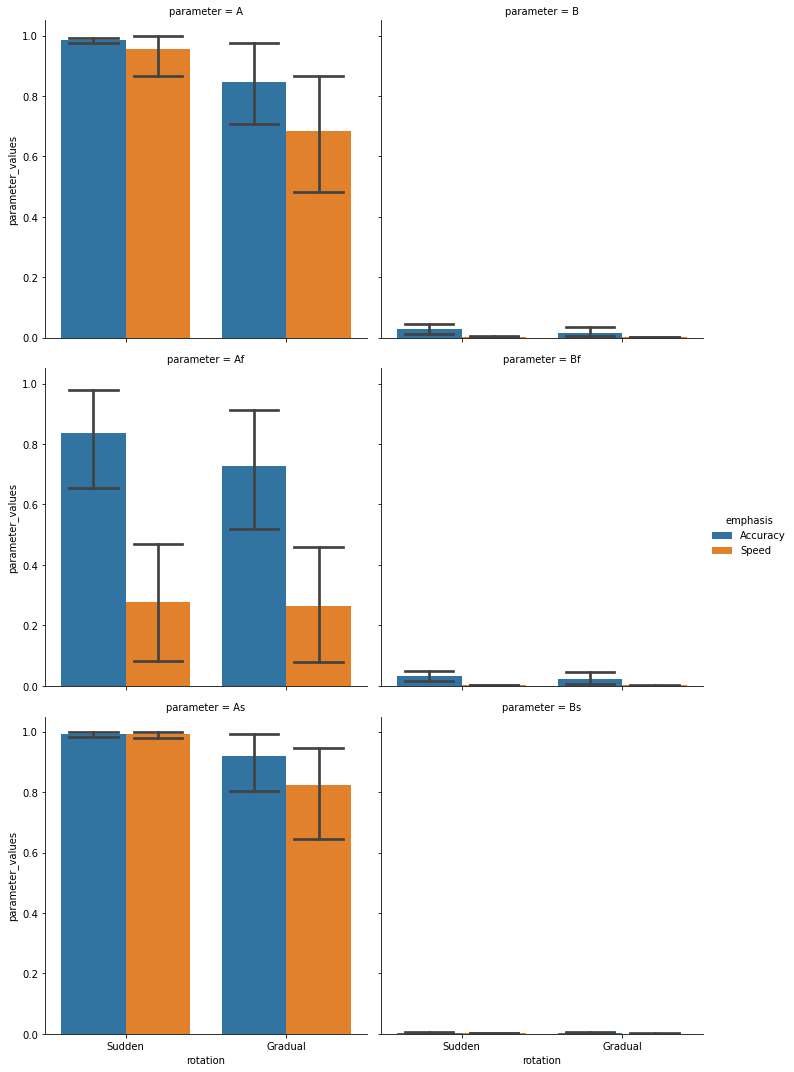

In [11]:
sns.catplot(x = 'rotation', hue = 'emphasis', y = 'parameter_values', col = 'parameter', 
            col_wrap=2, data = params_df, kind = 'bar', capsize = 0.3)

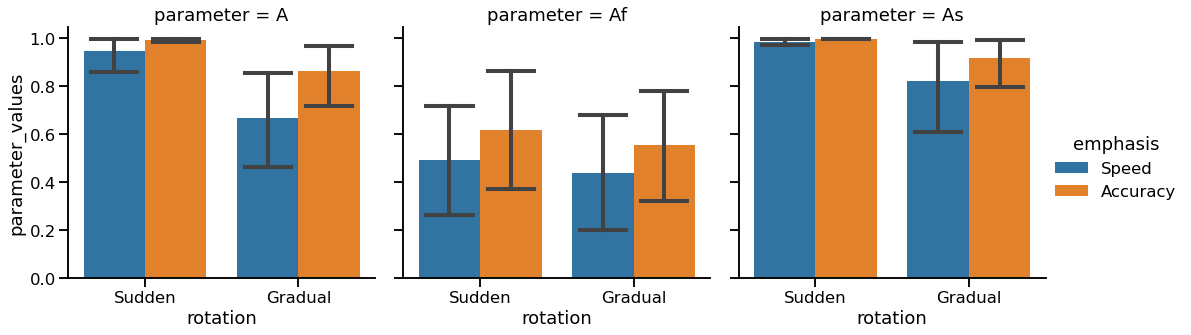

In [8]:
sns.set_context('talk')
sns.catplot(x = 'rotation', hue = 'emphasis', y = 'parameter_values', col = 'parameter', hue_order=['Speed', 'Accuracy'],
            data = params_df.loc[((params_df.parameter == 'A') | (params_df.parameter == 'Af') | (params_df.parameter == 'As'))], kind = 'bar', capsize = 0.3)

In [13]:
params['condition'] = params['rotation'] + ' ' + params['emphasis']

In [14]:
params['Bf-B'] = params['Bf'] - params['B']
params['B-Bs'] = params['B'] - params['Bs']
params['log(Bf/B)'] = np.log(params['Bf']/params['B'])
params['log(B/Bs)'] = np.log(params['B']/params['Bs'])

params['Single'] = params['B']*params['A']
params['Fast'] = params['Bf']*params['Af']
params['Slow'] = params['Bs']*params['As']


In [15]:
params = params.drop(['A', 'B', 'Af', 'Bf', 'As', 'Bs', 'rotation', 'emphasis', 'Bf-B', 'B-Bs', 'log(Bf/B)', 'log(B/Bs)'], axis = 1)
participant_means = params[['Single', 'Fast', 'Slow']].mean(axis = 1)
#grand_mean_BA = params['Single'].mean()
#grand_mean_BfAf = params['Fast'].mean()
#grand_mean_BsAs = params['Slow'].mean()


params['Single'] = params['Single'] - participant_means + np.mean(participant_means)
params['Fast'] = params['Fast'] - participant_means + np.mean(participant_means)
params['Slow'] = params['Slow'] - participant_means + np.mean(participant_means)


In [16]:
params_melt = params.melt(id_vars=['participant_id', 'condition'], var_name='State', value_name='param_values')

(-0.02, 0.06)

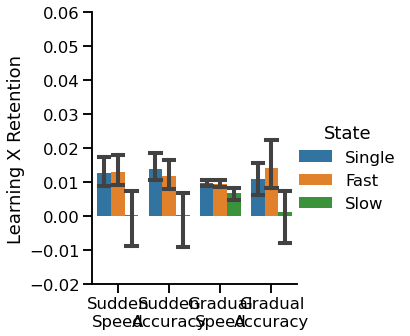

In [17]:

g = sns.catplot(x = 'condition', y = 'param_values', hue = 'State',
            kind = 'bar', capsize = 0.2, order = ['Sudden Speed', 'Sudden Accuracy', 'Gradual Speed', 'Gradual Accuracy'],
            data = params_melt, dodge = True)
g.axes[0][0].set_xticklabels(['Sudden\nSpeed', 'Sudden\nAccuracy', 'Gradual\nSpeed', 'Gradual\nAccuracy'])
g.axes[0][0].set_ylabel('Learning X Retention')
g.axes[0][0].set_xlabel(None)
g.axes[0][0].set_ylim((-0.02, 0.06))
#plt.legend(title = 'Model', labels=['Single', 'Fast', 'Slow'])
#plt.show(g)
#plt.savefig('C:\\Users\\Tejas\\OneDrive - University of Massachusetts\\PLoS_comp_bio\\exp2_lean_x_reten.png', dpi = 600)

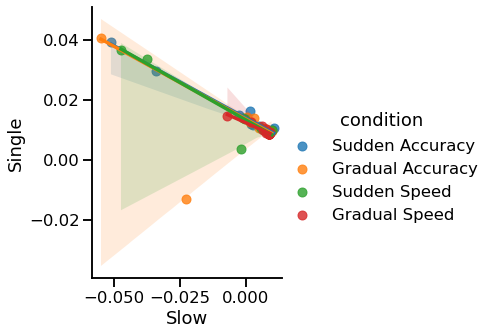

In [32]:
sns.lmplot(x = 'Slow', y = 'Single', data = params, hue = 'condition', robust = True)

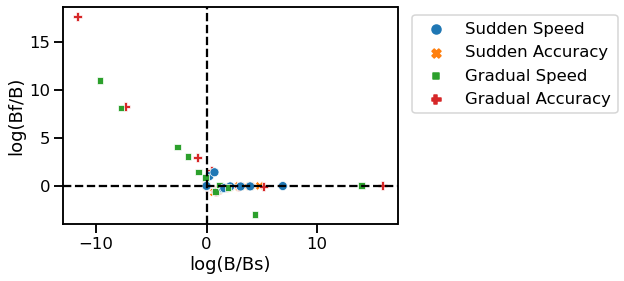

In [17]:
sns.set_context('talk')
g = sns.scatterplot(y = 'log(Bf/B)', x = 'log(B/Bs)', style = 'condition',  style_order=['Sudden Speed', 'Sudden Accuracy', 'Gradual Speed', 'Gradual Accuracy'],
                    hue = 'condition', hue_order=['Sudden Speed', 'Sudden Accuracy', 'Gradual Speed', 'Gradual Accuracy'],
                   data = params)
g.axes.axhline(y = 0, ls = '--', color = 'black')
g.axes.axvline(x = 0, ls = '--', color = 'black')
plt.legend(bbox_to_anchor=(1.02, 1), loc = 'upper left')

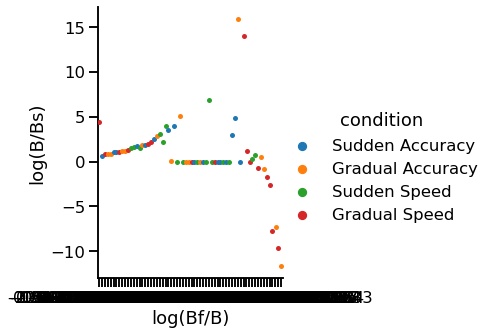

In [20]:
sns.catplot(x='log(Bf/B)', y='log(B/Bs)', hue = 'condition', data = params[['log(Bf/B)', 'log(B/Bs)', 'condition']])

In [21]:
params_mean = params.groupby('condition').mean()

In [27]:
params_str = params.groupby('condition').std()/4

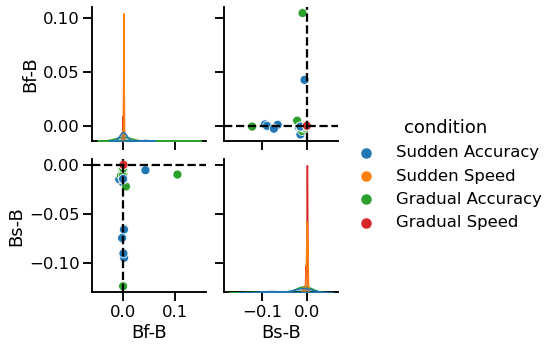

In [109]:
g = sns.pairplot(data = params[['Bf-B', 'Bs-B', 'condition']], hue = 'condition', kind = 'scatter')
#sns.lmplot(x = 'B', y = 'Bs', data = params, hue = 'emphasis')
g.axes[0][1].axhline(y = 0, ls = '--', color = 'black')
g.axes[1][0].axhline(y = 0, ls = '--', color = 'black')
g.axes[0][1].axvline(x = 0, ls = '--', color = 'black')
g.axes[1][0].axvline(x = 0, ls = '--', color = 'black')


In [18]:
model = smf.ols('parameter_values~rotation*emphasis', data = params_df.query('parameter == "B"')).fit()
aov = sm.stats.anova_lm(model)
aov

,df,sum_sq,mean_sq,F,PR(>F)
rotation,1.0,0.001527,0.001527,0.909439,0.344362
emphasis,1.0,0.003999,0.003999,2.381237,0.128433
rotation:emphasis,1.0,0.001286,0.001286,0.765451,0.385365
Residual,56.0,0.094054,0.001680,NaN,NaN


In [4]:
num_itr = 100
num_participants = 60
all_A = np.zeros(num_participants*num_itr)
all_B = np.zeros(num_participants*num_itr)
all_Af = np.zeros(num_participants*num_itr)
all_Bf = np.zeros(num_participants*num_itr)
all_As = np.zeros(num_participants*num_itr)
all_Bs = np.zeros(num_participants*num_itr)
all_alphas = np.zeros(num_participants*num_itr)
all_Vs_single = np.zeros(num_participants*num_itr)
all_Vs_dual = np.zeros(num_participants*num_itr)

for i in range(num_itr):
    all_A[i*num_participants:(i+1)*num_participants] = fits_single[i][:, 0]
    all_B[i*num_participants:(i+1)*num_participants] = fits_single[i][:, 1]
    all_Af[i*num_participants:(i+1)*num_participants] = fits_dual[i][:, 0]
    all_Bf[i*num_participants:(i+1)*num_participants] = fits_dual[i][:, 1]
    all_As[i*num_participants:(i+1)*num_participants] = fits_dual[i][:, 2]
    all_Bs[i*num_participants:(i+1)*num_participants] = fits_dual[i][:, 3]

    all_Vs_single[i*num_participants:(i+1)*num_participants] = fits_single[i][:, -3]
    all_Vs_dual[i*num_participants:(i+1)*num_participants] = fits_dual[i][:, -3]
    #all_alphas[i*num_participants:(i+1)*num_participants] = 1- fits_hybrid[i][:, 0]

In [5]:
parameters_df = pd.DataFrame({'Participant_Id': np.tile(range(num_participants), num_itr),
                         'Rotation': np.tile(['Sudden', 'Sudden', 'Gradual', 'Gradual'], num_itr*int(num_participants/4)), 
                         'Emphasis': np.tile(['Speed', 'Accuracy'], num_itr*int(num_participants/2)),
                         'A': all_A,
                         'B': all_B,
                         'Af': all_Af,
                         'Bf': all_Bf,
                         'As': all_As,
                         'Bs': all_Bs,
                         #'V': (all_Vs_single - all_Vs_dual)/(np.mean(all_Vs_single - all_Vs_dual))
                         #'Alpha': all_alphas
                        })
parameters_df['Condition'] = parameters_df['Rotation'] + '_' + parameters_df['Emphasis']

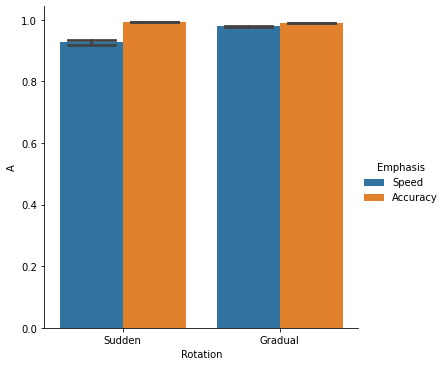

In [6]:
sns.catplot(x="Rotation", y='A',data = parameters_df, hue = 'Emphasis', kind = 'bar', capsize = 0.3)


In [10]:
parameter_means = parameters_df.groupby(['Participant_Id', 'Rotation', 'Emphasis']).mean().reset_index()
#parameter_means['ratio'] = (parameter_means['As'] )/(parameter_means['Af'] + parameter_means['As'])
#parameter_means['Dual_Selected'] = dual_selected.sort_values(by = 'Participant_Id')['Dual_Selected']

In [288]:
stat.ttest_ind(parameter_means[parameter_means['Dual_Selected'] > 60]['B'], parameter_means[parameter_means['Dual_Selected'] < 40]['B'])

KeyError: 'Dual_Selected'

In [11]:
parameter_means_melt = parameter_means.melt(id_vars=['Participant_Id', 'Rotation', 'Emphasis'], var_name='Parameters', value_name='Parameter_Values')

In [290]:
dual_selected = pd.read_csv('dual_selected_testset.csv')

In [291]:
dual_selected['Participant_Id'] = np.concatenate((np.arange(0, 60, 4), np.arange(1, 60, 4), np.arange(2, 60, 4), np.arange(3, 60, 4)))
dual_selected.sort_values(by = 'Participant_Id')['Dual_Selected']

0     23
15    59
30    12
45    89
1     46
16    72
31    97
46    59
2     97
17    95
32    29
47    85
3      3
18    55
33    14
48    93
4     10
19    93
34    21
49    65
5     90
20    94
35    40
50    81
6     50
21    97
36    78
51    17
7     81
22    64
37     7
52    98
8     50
23    52
38     4
53    97
9     86
24    81
39    33
54    89
10    11
25    99
40    11
55    97
11     5
26    11
41    12
56    86
12    59
27    88
42    43
57    86
13    92
28    70
43    75
58    82
14    37
29    88
44    19
59    96
Name: Dual_Selected, dtype: int64

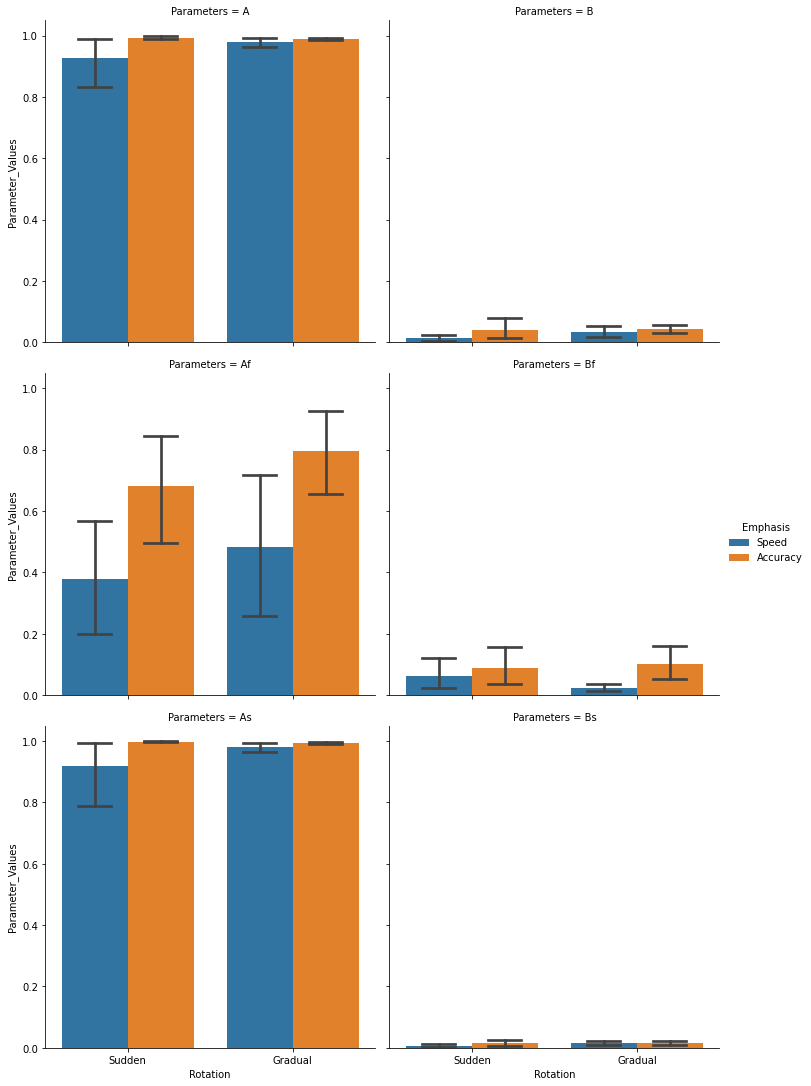

In [12]:
sns.catplot(x = 'Rotation', y = 'Parameter_Values', hue = 'Emphasis', col = 'Parameters', col_wrap = 2,
            data = parameter_means_melt, kind = 'bar', capsize = 0.2)


In [13]:
param = 'B'
stat.ttest_ind(parameter_means[param][parameter_means['Rotation'] == 'Gradual'], parameter_means[param][parameter_means['Rotation'] == 'Sudden'])

Ttest_indResult(statistic=1.0639831021234192, pvalue=0.29174607288457033)

In [20]:
model = smf.ols('B~Rotation*Emphasis', data = parameter_means).fit()
aov = sm.stats.anova_lm(model)
aov

,df,sum_sq,mean_sq,F,PR(>F)
Rotation,1.0,0.002008,0.002008,1.160612,0.285958
Emphasis,1.0,0.004978,0.004978,2.876863,0.095414
Rotation:Emphasis,1.0,0.001014,0.001014,0.585988,0.447189
Residual,56.0,0.096898,0.001730,NaN,NaN


In [94]:
alpha_medians = alpha_df.groupby(['Participant_Id', 'Rotation', 'Emphasis']).median().reset_index()
alpha_means = alpha_df.groupby(['Participant_Id', 'Rotation', 'Emphasis']).mean().reset_index()


Text(0.5, 0.8793567452082017, '*')

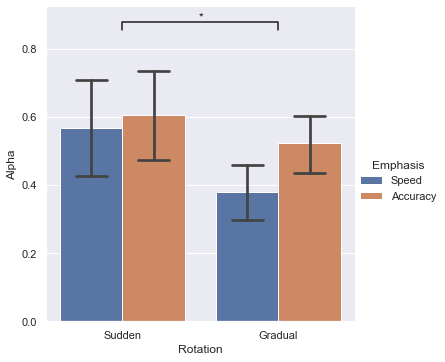

In [95]:
x1, x2 = 0, 1
y, h, col = alpha_means['Alpha'].max() - 0.2, 0.025, 'k'

sns.catplot(x = 'Rotation', y = 'Alpha', hue = 'Emphasis', data = alpha_means, kind = 'bar', capsize = 0.2)
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)


In [10]:
conc = pd.read_csv('conc.csv')

In [11]:
parameters_means['Model_Selected'] = 'Dual_Selected'

In [12]:
parameters_means['Model_Selected'][parameters_means['Participant_Id'].isin(np.unique(conc[conc['Dual_Selected'] < 50]['Participant_Id']))] = 'Single_Selected'

<ipython-input-12-d289fa70e1c0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters_means['Model_Selected'][parameters_means['Participant_Id'].isin(np.unique(conc[conc['Dual_Selected'] < 50]['Participant_Id']))] = 'Single_Selected'


In [13]:
parameters_means['Dual_Selected'] = 1
parameters_means['Dual_Selected'][parameters_means['Model_Selected'] == 'Single_Selected'] = 0

<ipython-input-13-0fc71f62f964>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters_means['Dual_Selected'][parameters_means['Model_Selected'] == 'Single_Selected'] = 0


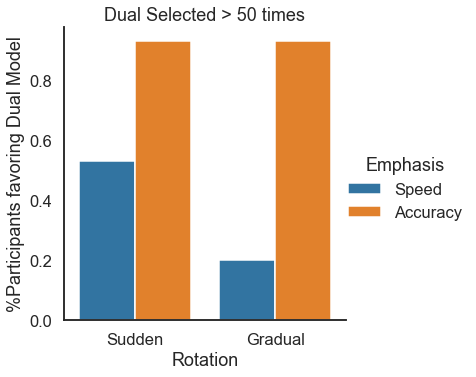

In [14]:
sns.set_context('talk')
sns.set_style('white')
cp = sns.catplot(data = parameters_means,
           x = 'Rotation', y = 'Dual_Selected', hue = 'Emphasis', kind = 'bar', ci = None)
plt.title('Dual Selected > 50 times')
cp.set_ylabels('%Participants favoring Dual Model')

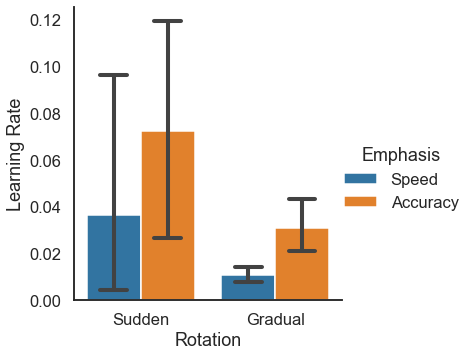

In [9]:
c = sns.catplot(data = parameters_means,
           x = 'Rotation', y = 'B', hue = 'Emphasis', kind = 'bar', capsize = 0.2)
c.set(ylabel = 'Learning Rate')
#plt.title('Best fit by Single state')
#sns.boxplot(data = parameters_means,
#           x = 'Model_Selected', y = 'B', 
#            hue = 'Emphasis')
#plt.ylim((-0.2, 0.5))

In [42]:
model = smf.ols('Dual_Selected~Rotation*Emphasis', data = parameter_means[parameter_means['B']]).fit()
aov = sm.stats.anova_lm(model)
aov

KeyError: "None of [Float64Index([ 0.04283847986935048,  0.06279240528483808,  0.02603918295167823,\n               0.17899127966415612,  0.09962033003528861,   0.4680476273766781,\n               0.31933107549947715,  0.05978132827610681,   0.7910521960018442,\n                0.4517147664548228,   0.0681397784864444,  0.22082249475341648,\n              0.012341958133828103,  0.03443818985028595,  0.06345062864169426,\n                0.8295185954154907, 0.017881365274240103,   0.8629178115882645,\n              0.050835562610120316,  0.16098233780545373, 0.038292978187867616,\n                0.3457808909897438,  0.10650796391163048,   0.4442726208916362,\n               0.26278855922669486,  0.12134899963907711,  0.09966687773792587,\n               0.05394017037903433,   0.4475444123471095,  0.14930548370307936,\n              0.048075727068772306,   0.3074964695595582,  0.15406514205049943,\n               0.05698297773671179,  0.04875991671396991,   0.8546998790494442,\n                0.0920340720351489,  0.41021151035876224,    0.051215484288455,\n               0.13302647999195602,  0.39141722074698004,   0.8704243562987977,\n               0.16416206468619587,   0.5385704352485159,  0.08824770134237853,\n              0.057455634928114035, 0.057384288413874225,  0.08271684877889947,\n               0.27762637757501485,  0.33309752274574256, 0.053870200543525246,\n                 0.529029316661049,   0.6770287574000146,    0.649531154106255,\n               0.14698155532215873,   0.7273698491425329,   0.1572509204833082,\n                 0.809031128465258,  0.04489456852998236,\n                0.8894577102651301],\n             dtype='float64')] are in the [columns]"

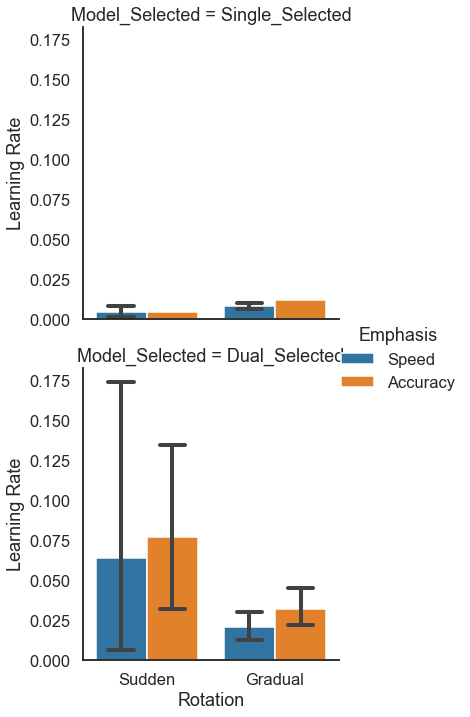

In [37]:
c = sns.catplot(data = parameters_means,
           x = 'Rotation', y = 'B', hue = 'Emphasis', kind = 'bar', capsize = 0.2, row = 'Model_Selected')
#plt.title('Best fit by Single state')
#plt.hlines(y = np.max(parameters_means['B'][parameters_means['Model_Selected'] == 'Single_Selected']), 
#           xmin = -0.5, xmax = 2, color = 'black', linestyles='--')
c.set(ylabel = 'Learning Rate')

Text(0.5, 1.0, 'Best fit by Single state')

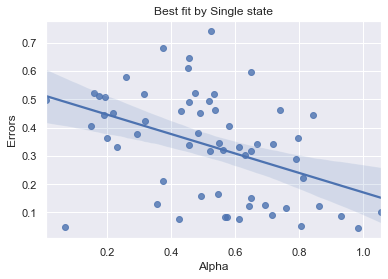

In [68]:
sns.regplot(data = parameters_means,
           x = 'Alpha', y = 'Errors')
plt.title('Best fit by Single state')


In [4]:
curvatures_smooth = pickle.load(open('curvatures_smooth.pickle', 'rb'))

curvatures_smooth = curvatures_smooth/90.0

In [25]:
fits_dual = pickle.load(open('fit_dual_CV_640_bestfit_starting_point.pickle', 'rb'))

In [28]:
num_itr = 100
num_trials = 704
model_errors_fast = np.zeros((num_itr, 60, num_trials))
model_errors_slow = np.zeros((num_itr, 60, num_trials))
r_est = np.zeros((num_itr, 60, num_trials))
e_est = np.zeros((num_itr, 60, num_trials))
for i in range(num_itr):
    for participant in range(60):
        if participant%4 == 0 or participant%4 == 1:
            #e_est[participant], r_est[participant], model_errors_fast[participant], model_errors_slow[participant] = dual_model_sudden(num_trials, fits_dual_nocv[participant][0], fits_dual_nocv[participant][1], fits_dual_nocv[participant][2], fits_dual_nocv[participant][3])
            e_est[i][participant], r_est[i][participant], model_errors_fast[i][participant], model_errors_slow[i][participant] = dual_model_sudden(num_trials, fits_dual[i][participant][0], fits_dual[i][participant][1], fits_dual[i][participant][2], fits_dual[i][participant][3])
        else:
            #e_est[participant], r_est[participant], model_errors_fast[participant], model_errors_slow[participant] = dual_model_gradual(num_trials, fits_dual_nocv[participant][0], fits_dual_nocv[participant][1], fits_dual_nocv[participant][2], fits_dual_nocv[participant][3])
            e_est[i][participant], r_est[i][participant], model_errors_fast[i][participant], model_errors_slow[i][participant] = dual_model_gradual(num_trials, fits_dual[i][participant][0], fits_dual[i][participant][1], fits_dual[i][participant][2], fits_dual[i][participant][3])
        

In [30]:
num_itr = 100
estimates_df = pd.DataFrame({'Participant_Id': np.tile(np.repeat(np.arange(60), 704), num_itr), 
                             'Trial': np.tile(np.arange(704), 60*num_itr), 
                             'Block': np.tile(np.repeat(np.arange(1, 12), 64), 60*num_itr), 
                             'Errors': np.tile(np.ravel(curvatures_smooth[:, 1:, :]), num_itr),
                             'E_est': np.ravel(e_est),
                             'R_est': np.ravel(r_est),
                             'Fast_est': np.ravel(model_errors_fast),
                             'Slow_est': np.ravel(model_errors_slow),
                             'Rotation': np.tile(np.repeat(['Sudden', 'Sudden', 'Gradual', 'Gradual'], 704), 15*num_itr), 
                             'Emphasis': np.tile(np.repeat(['Speed', 'Accuracy'], 704), 30*num_itr), 
                             'slow_by_total': np.ravel(model_errors_slow)/(np.ravel(r_est) + 0.00001),
                             'fast_by_total': np.ravel(model_errors_fast)/(np.ravel(r_est) + 0.00001), 
                             'slow_by_fast': np.ravel(model_errors_slow)/(np.ravel(model_errors_fast) )

                            })
estimates_df['Slow_minus_Fast'] = estimates_df['Slow_est'] - estimates_df['Fast_est']


<ipython-input-30-2dc4d4ca5efe>:14: RuntimeWarning: invalid value encountered in true_divide
  'slow_by_fast': np.ravel(model_errors_slow)/(np.ravel(model_errors_fast) )


In [31]:
estimate_means = estimates_df.groupby(['Participant_Id', 'Block', 'Rotation', 'Emphasis']).mean().reset_index()
estimate_means['Condition'] = estimate_means['Rotation'] + '_' + estimate_means['Emphasis']
estimate_means_melted = estimate_means.melt(['Participant_Id', 'Block', 'Rotation', 'Emphasis' ,'Trial',  'Condition'], var_name='Estimates')

In [32]:
estimate_sums

,Participant_Id,Block,Rotation,Emphasis,Trial,Errors,E_est,R_est,Fast_est,Slow_est,slow_by_total,fast_by_total,slow_by_fast,Slow_minus_Fast,Condition
0,0,1,Sudden,Speed,2016,60.160816,61.468286,2.531714,1.462423,1.069291,26.601008,36.381105,46.064118,-0.393132,Sudden_Speed
1,0,2,Sudden,Speed,6112,59.421141,61.148803,2.851197,1.646967,1.204230,27.024930,36.960707,46.795520,-0.442738,Sudden_Speed
2,0,3,Sudden,Speed,10208,54.167461,61.148782,2.851218,1.646980,1.204239,27.024930,36.960707,46.795520,-0.442741,Sudden_Speed
3,0,4,Sudden,Speed,14304,62.084895,61.148782,2.851218,1.646980,1.204239,27.024930,36.960707,46.795520,-0.442741,Sudden_Speed
4,0,5,Sudden,Speed,18400,69.023417,61.148782,2.851218,1.646980,1.204239,27.024930,36.960707,46.795520,-0.442741,Sudden_Speed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
655,59,7,Gradual,Accuracy,26592,14.545978,11.204372,38.573406,6.426279,32.147126,53.309173,10.689764,324.144463,25.720847,Gradual_Accuracy
656,59,8,Gradual,Accuracy,30688,15.474874,12.235057,44.653832,7.018690,37.635142,53.919400,10.079682,346.695931,30.616453,Gradual_Accuracy
657,59,9,Gradual,Accuracy,34784,10.368877,13.262619,50.737381,7.609270,43.128111,54.385469,9.613723,365.861180,35.518841,Gradual_Accuracy
658,59,10,Gradual,Accuracy,38880,11.489394,10.908980,53.091020,6.288180,46.802840,56.416266,7.582963,477.326561,40.514660,Gradual_Accuracy


In [33]:
estimate_sums = estimates_df.groupby(['Participant_Id', 'Block','Rotation', 'Emphasis']).sum().reset_index()
estimate_sums['Condition'] = estimate_sums['Rotation'] + '_' + estimate_sums['Emphasis']
estimate_sums_melted = estimate_sums.melt(['Participant_Id', 'Rotation', 'Emphasis' ,'Trial', 'Condition'], var_name='Estimates')

In [1]:
sns.set(font_scale = 1.5)
sns.set_style('white')
colors = [ '#808A87', '#292421']
#'#D3D3D3',
sns.set_palette(sns.color_palette(colors))

g = sns.catplot(x = 'Emphasis', y = 'slow_by_total', hue = 'Rotation', hue_order=['Gradual', 'Sudden'],
            data = estimate_means[estimate_means['Block'] == 11], kind = 'bar', capsize = 0.2)
hatches = ['//', '', '//', '']
num_locations = len(estimate_means.Rotation.unique())
for i, patch in enumerate(g.ax.patches):
    patch.set_hatch(hatches[i])

g.set(ylabel = "Relative Contribution of Slow State")
plt.title('Rotation Phase')
plt.savefig('C:\\Users\\Tejas\\OneDrive - University of Massachusetts\\PLoS_comp_bio\\figures\\slow_by_total_rotation.png', dpi = 600, bbox_inches = 'tight')
model = smf.ols('slow_by_total~Rotation*Emphasis', data = estimate_sums[estimate_means['Block'] == 11]).fit()
aov = sm.stats.anova_lm(model)
aov

NameError: name 'sns' is not defined

Text(0.5, 1.0, 'Rotation Phase')

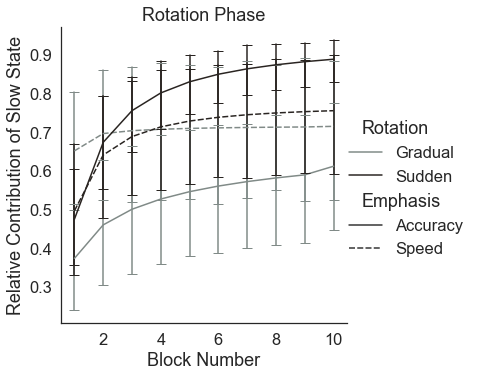

In [37]:
sns.set_style('white')
colors = ['#808A87', '#292421']
sns.set_palette(sns.color_palette(colors))

g = sns.relplot(x = 'Block', y = 'slow_by_total', hue = 'Rotation', hue_order=['Gradual', 'Sudden'], 
                data = estimate_means[estimate_means['Block'] < 11], 
                style = 'Emphasis', style_order=['Accuracy', 'Speed'], 
                kind = 'line', err_style = 'bars', err_kws = {"capsize": 5}
               )
#new_labels = ['Sudden Speed', 'Sudden Accuracy', 'Gradual Speed', 'Gradual Accuracy']

#plt.legend(loc='right')


#for t, l in zip(g._legend.texts, new_labels): t.set_text(l)
#plt.legend(bbox_to_anchor=(1.42, 0.5), loc='right', borderaxespad=0)

g.set(xlabel = "Block Number", ylabel = "Relative Contribution of Slow State")
plt.savefig('C:\\Users\\Tejas\\OneDrive - University of Massachusetts\\PLoS_comp_bio\\figures\\slow_by_total_individual_blocks.png', dpi = 600, bbox_inches = 'tight')
plt.title('Rotation Phase')
#plt.ylim((0, 1))

In [265]:
#blockwise = np.reshape(np.array(estimate_means[estimate_means['Block'] <= 10]['slow_by_total']), (60, 10))
#e = np.sum(blockwise, axis = 1)


final_block_errors = pd.DataFrame({'Participant_Id': (np.arange(60)), 
                                   'Washout_Errors': np.ravel(np.mean(curvatures_smooth[:, -1, :], 1)),  
                                   'slow_by_total': e
                                   #'slow_by_total': estimate_means[estimate_means['Block'] == 10]['slow_by_total']
                                  })

In [113]:
trial_estimates =  estimates_df.groupby(['Participant_Id', 'Trial', 'Block', 'Rotation', 'Emphasis']).mean().reset_index()

In [114]:
estimates_per_participant = trial_estimates.groupby(['Participant_Id', 'Rotation', 'Emphasis', 'Block']).sum().reset_index()

In [158]:
estimates_per_participant['slow_by_total'] = estimates_per_participant['Slow_est']/estimates_per_participant['R_est']


Text(0.5, 1.0, 'Blocks 6 through 10, Reg. lines from bottom to top')

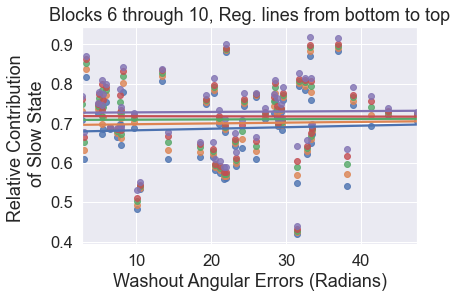

In [345]:
blocks = 5
for blocks in range(6, 11):
    corr_df = pd.DataFrame({'Participant_Id': range(60), 
                            #'Slow_by_Total': np.array(estimates_per_participant[estimates_per_participant['Block'] == 10]['slow_by_total']), 
                            'Slow_by_Total': np.sum(np.reshape(np.array(estimates_per_participant[estimates_per_participant['Block'] == blocks]['slow_by_total']), (60, 1)), axis = 1),
                            'Washout_Errors': np.array(estimates_per_participant[estimates_per_participant['Block'] == 11]['Errors'])
                           }
                          )
    g = sns.regplot(data = corr_df,
               x = 'Washout_Errors', y = 'Slow_by_Total', ci = None, label = blocks)
    g.set(xlabel = "Washout Angular Errors (Radians)", ylabel = "Relative Contribution \n of Slow State")
    #g.set_label("Block: " + str(blocks))
g.set_title('Blocks 6 through 10, Reg. lines from bottom to top')
#plt.savefig('C:\\Users\\Tejas\\OneDrive - University of Massachusetts\\PLoS_comp_bio\\figures\\scatter_plot_slowbytotal_washout.png', dpi = 600, bbox_inches = 'tight')

Text(0.5, 1.0, 'All Rotation Blocks Added')

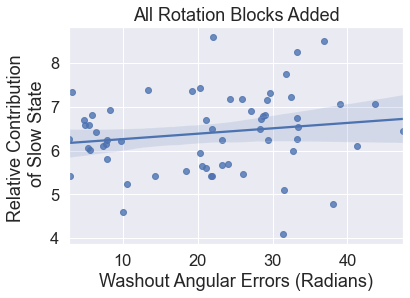

In [341]:
blocks = 10
corr_df = pd.DataFrame({'Participant_Id': range(60), 
                        #'Slow_by_Total': np.array(estimates_per_participant[estimates_per_participant['Block'] == 10]['slow_by_total']), 
                        'Slow_by_Total': np.sum(np.reshape(np.array(estimates_per_participant[estimates_per_participant['Block'] <= blocks]['slow_by_total']), (60, 10)), axis = 1),
                        'Washout_Errors': np.array(estimates_per_participant[estimates_per_participant['Block'] == 11]['Errors'])
                       }
                      )
g = sns.regplot(data = corr_df,
           x = 'Washout_Errors', y = 'Slow_by_Total', label = blocks)
g.set(xlabel = "Washout Angular Errors (Radians)", ylabel = "Relative Contribution \n of Slow State")
g.set_title('All Rotation Blocks Added')

Text(0.5, 1.0, 'Block: 5')

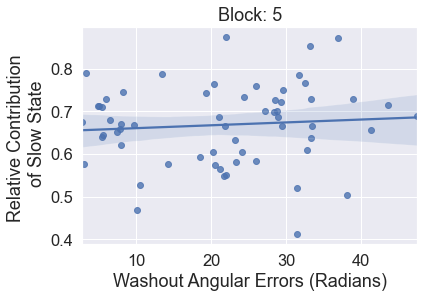

In [164]:
stat.pearsonr(corr_df['Washout_Errors'], corr_df['Slow_by_Total'])

(0.4083055033288037, 0.0012012020385669103)

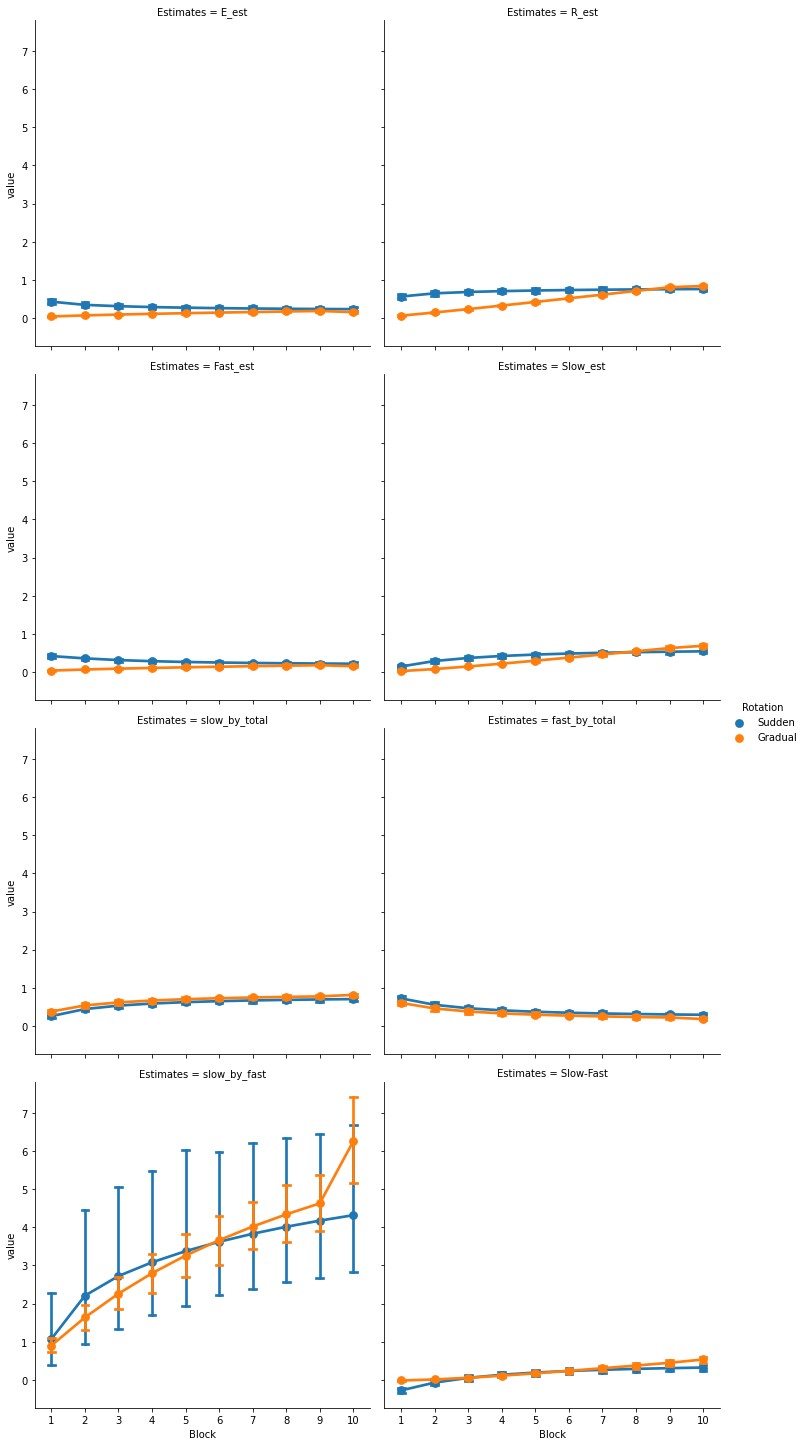

In [18]:
sns.catplot(x = 'Block', y = 'value', hue = 'Rotation', col = 'Estimates', col_wrap=2, 
            data = estimate_means_melted[estimate_means_melted['Block'] < 11], kind = 'point', capsize = 0.2)

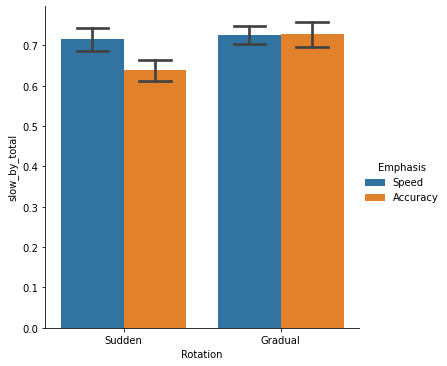

In [53]:
sns.catplot(data = estimate_means[estimate_means['Block'] < 11],
           x = 'Rotation', y = 'slow_by_total', hue = 'Emphasis', 
                kind = 'bar', capsize = 0.2)


PatsyError: Error evaluating factor: NameError: name 'fast_by_total' is not defined
    fast_by_total~Rotation*Emphasis
    ^^^^^^^^^^^^^

In [57]:
stat.binom_test(60, 100, 0.5)

0.05688793364098078